In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras

from scipy.stats import probplot
from scipy.stats import normaltest

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [2]:
import matplotlib as mpl
print(mpl.__version__)

3.2.1


In [3]:
inferenceLocations = ['Amazon-EC2','Desktop','Pocketbeagle','Beaglebone']
inferenceLocationsBold = [r'\textbf{Amazon-EC2}',r'\textbf{Desktop}',r'\textbf{Pocketbeagle}',r'\textbf{Beaglebone}']
basePath = 'data/Latency Tests/Results/'
numSamples = 700
numModels = 8

latencyVals = np.zeros((numSamples,numModels,len(inferenceLocations)))
scoreVals = np.zeros((numSamples,numModels,len(inferenceLocations)))
columns = None

In [4]:
for i in range(4):
    thisDF = pd.read_csv(basePath + inferenceLocations[i] + '_Loaded_Train_Healthy.csv')
    
    print(thisDF.values.shape)
    
    if thisDF.values.shape[1] > 8:
        latencyVals[...,i] = thisDF.values[:,1:]
    else:
        latencyVals[...,i] = thisDF.values
    thisDF = pd.read_csv(basePath + inferenceLocations[i] + '_Loaded_Train_Healthy_values.csv')
    if thisDF.values.shape[1] > 8:
        scoreVals[...,i] = thisDF.values[:,1:]
    else:
        scoreVals[...,i] = thisDF.values
    if i == 0:
        columns = thisDF.columns[1:]
latencyVals *= 1e3

(700, 9)
(700, 8)
(700, 8)
(700, 8)


In [5]:
columns

Index(['PCA-GMM', 'AE', 'CNN-AE', 'CNN-AE-Lite', 'PCA-GNB', 'MLP', 'CNN-MLP',
       'CNN-MLP-Lite'],
      dtype='object')

In [6]:
print(np.mean(latencyVals[:,2,1]) - np.mean(latencyVals[:,3,1]))
print(np.amax(latencyVals[:,2,1]) - np.amax(latencyVals[:,3,1]))

print(np.mean(latencyVals[:,6,1]) - np.mean(latencyVals[:,7,1]))
print(np.amax(latencyVals[:,6,1]) - np.amax(latencyVals[:,7,1]))

print(np.mean(scoreVals[:,2,1]) - np.mean(scoreVals[:,3,1]))
print(np.amax(np.abs(scoreVals[:,2,1] - scoreVals[:,3,1])))

print(np.mean(scoreVals[:,6,1]) - np.mean(scoreVals[:,7,1]))
print(np.amax(np.abs(scoreVals[:,6,1] - scoreVals[:,7,1])))

312.62957298571274
884.0222699999921
200.66822429714037
507.38749600002825
-1.874286698066996e-10
2.2351741790771484e-08
-1.7029899712639462e-10
2.384185789905402e-07


In [7]:
np.allclose(scoreVals[:,6,1],scoreVals[:,7,1])

print(np.amax(np.abs(scoreVals[:,2,1] - scoreVals[:,3,1])))

keras.metrics.mean_squared_error(scoreVals[:,6,1],scoreVals[:,7,1])

2.2351741790771484e-08


<tf.Tensor: shape=(), dtype=float64, numpy=5.887354099134021e-16>

mean latency, max latency, Max Score Difference, MSE

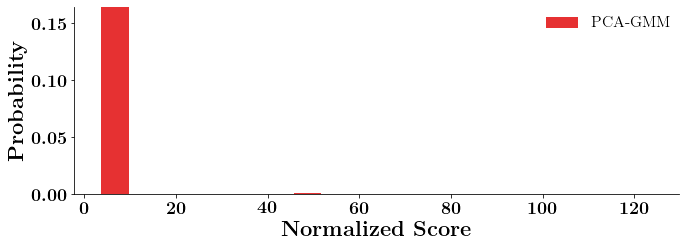

In [8]:
genplt.plot_histogram(latencyVals[:,:1,1],columns[:1],
               'Normalized Score',
               'Probability',
               'PCA-GMM_Historgram_All',
               template='wide',
               ymax=0.0,
               num_col=1)

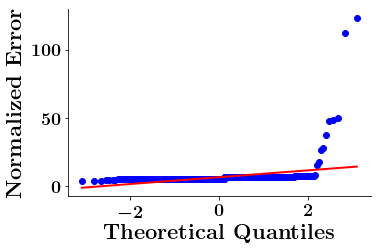

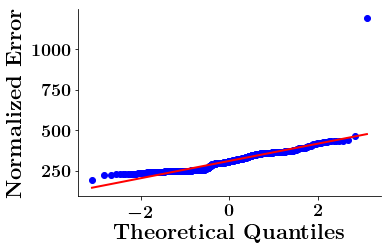

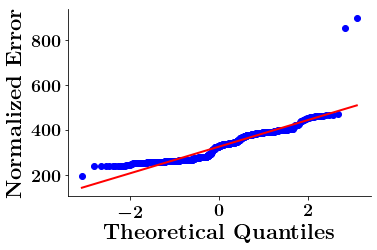

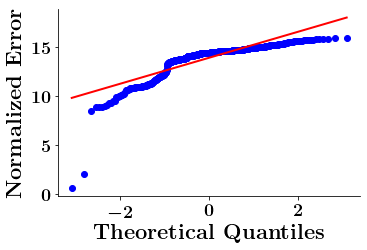

In [9]:
genplt.plot_normaltest(latencyVals[:,0,1],
                'Theoretical Quantiles',
                'Normalized Error',
                'Test')
genplt.plot_normaltest(latencyVals[:,1,1],
                'Theoretical Quantiles',
                'Normalized Error',
                'Test')

genplt.plot_normaltest(latencyVals[:,2,1],
                'Theoretical Quantiles',
                'Normalized Error',
                'Test')

genplt.plot_normaltest(latencyVals[:,3,1],
                'Theoretical Quantiles',
                'Normalized Error',
                'Test')

In [22]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

def box_plot(data,labels,ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),
             template='publication',title=''):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
    # Create an axes instance
#     ax = fig.add_axes([0,0,1,1])
    # Create the boxplot
    bp = plt.boxplot(data,
                    showfliers=False,
                    patch_artist=True,
                    meanline=False,
                    notch=False,
                    medianprops={'color':'black',
                                 'linewidth':2},
                    whiskerprops={'linewidth':2},
                    capprops={'linewidth':2})
    ax = plt.gca()
    
    for patch, color in zip(bp['boxes'], thisColors):
        # change outline color
        patch.set(color=color, linewidth=2)
        # change fill color
#         patch.set(facecolor = 'green' )
        # change hatch
#         patch.set(hatch = '/')
        patch.set_facecolor(color)

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_title(r'\textbf{' + title + '}',fontsize=22)

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()

In [23]:
[colors[i] for i in np.arange(3)]

['#e41a1c', '#377eb8', '#4daf4a']

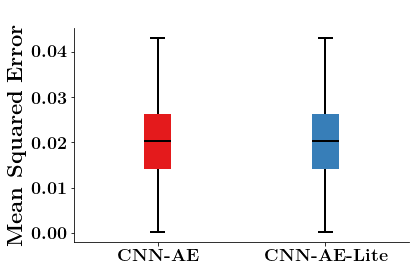

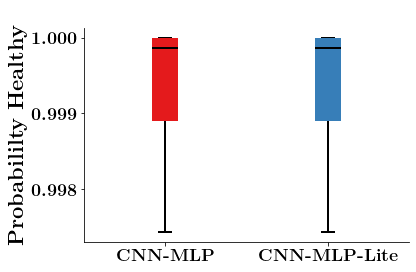

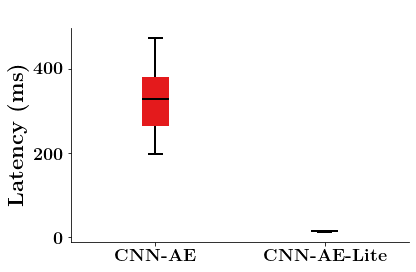

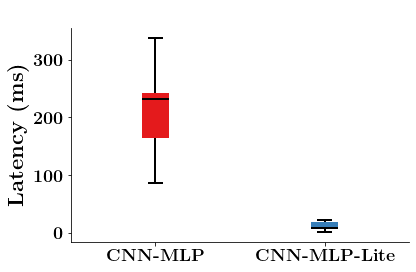

In [24]:
box_plot(scoreVals[:,np.array([2,3]),1],columns[np.array([2,3])],
         ylabel='Mean Squared Error',
        savefig=True,filename='CNN-AE_CompareScores_Boxplot',
        template='publication')

box_plot(scoreVals[:,np.array([6,7]),1],columns[np.array([6,7])],
         ylabel='Probabililty Healthy',
         savefig=True,filename='CNN-MLP_CompareScores_Boxplot',
         template='publication'
        )

box_plot(latencyVals[:,np.array([2,3]),1],columns[np.array([2,3])],
         savefig=True,filename='CNN-AE_CompareLatency_Boxplot',
         template='publication')
box_plot(latencyVals[:,np.array([6,7]),1],columns[np.array([6,7])],
         savefig=True,filename='CNN-MLP_CompareLatency_Boxplot',
         template='publication')


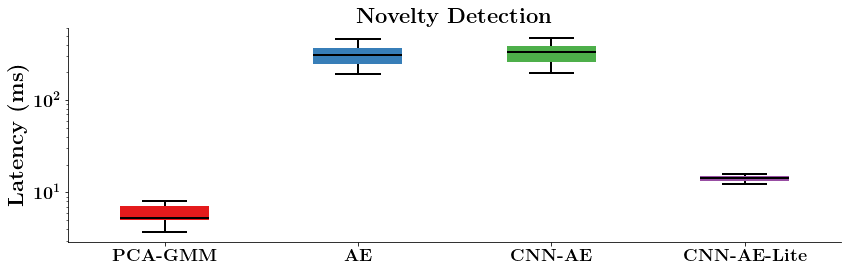

[6.5803168771415095, 310.141423459999, 326.5505999142847, 13.921026928571965]


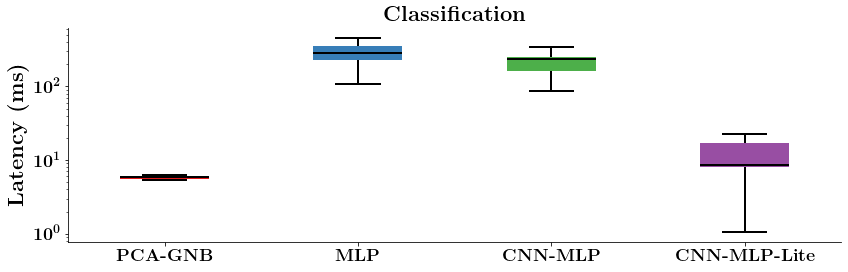

In [26]:
box_plot(latencyVals[:,:4,1],columns[:4],savefig=True,
         filename='Desktop_Latency_Anomaly_Boxplot',template='Wide',log_y=True,
         title='Novelty Detection'
         )

print([np.mean(latencyVals[:,i,1]) for i in range(4)])

box_plot(latencyVals[:,4:,1],columns[4:],savefig=True,filename='Desktop_Latency_Classification_Boxplot',
         template='wide',log_y=True,title='Classification')

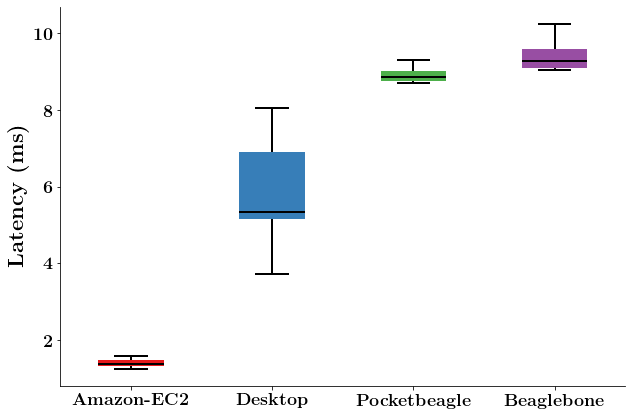

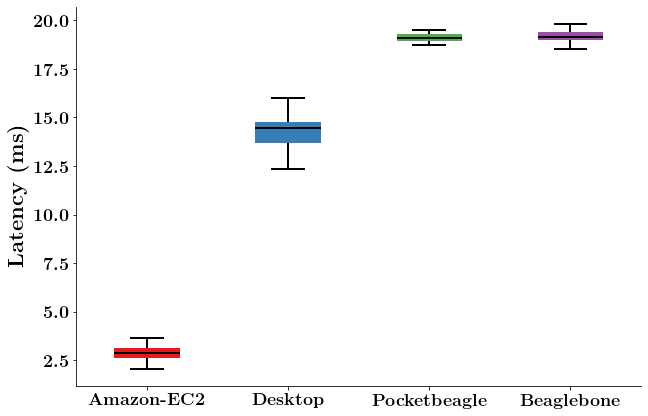

In [19]:

box_plot(latencyVals[:,0,:],inferenceLocationsBold,savefig=True,filename='PCA-GMM_Boxplot',template='Presentation')
box_plot(latencyVals[:,3,:],inferenceLocationsBold,savefig=True,filename='CNN-AE-Lite_Boxplot',template='Presentation')

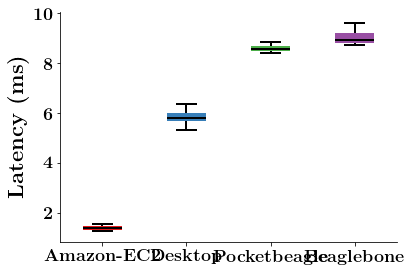

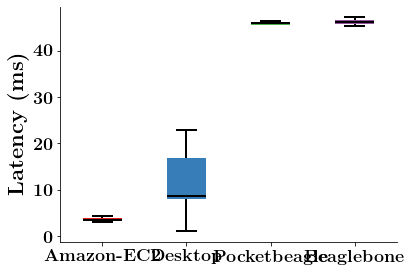

In [20]:

box_plot(latencyVals[:,4,:],inferenceLocationsBold,savefig=True,filename='PCA-GNB_Boxplot')



box_plot(latencyVals[:,7,:],inferenceLocationsBold,savefig=True,filename='CNN-MLP-Lite_Boxplot')

